In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

import pyspark.sql.functions as F
from pyspark.sql import Window

21/08/11 11:17:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
21/08/11 11:17:43 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


In [3]:
# Read in lan macs and customer data
df_lanmacs = spark.read.csv('lan_mac_data/lan_macs.csv', header=True, inferSchema=True, nullValue='', sep='|')
df_lanmacs = df_lanmacs.drop('customer', 'id', 'common__network_info__lan_mac', 'common__network_info__visible_wan_macs', 'common__network_info__wan_mac')
df_lanmacs = df_lanmacs.withColumnRenamed('erm__serial_number', 'SERIAL_NO')
df_lanmacs.limit(10).toPandas()

,SERIAL_NO,common__network_info__visible_lan_macs
0,J161103000272,[]
1,J191009D00574,[]
2,J160426003732,[]
3,J170308C00247,"[{""mac"":""0e:11:45:27:cb:2f""},{""mac"":""74:8f:3c:..."
4,J190809D02739,[]
5,None,None
6,J160725003753,"[{""mac"":""4c:ed:fb:b2:ff:5d""},{""mac"":""b0:72:bf:..."
7,J200813F01881,[]
8,J170215000028,[]
9,J191228F02970,"[{""mac"":""0c:98:38:27:98:9b"",""port"":3,""speed"":1..."


In [4]:
# Filter out empty values
df_lanmacs = df_lanmacs.dropna(subset=["common__network_info__visible_lan_macs"]) 
df_lanmacs = df_lanmacs.filter(F.col('common__network_info__visible_lan_macs') != '[]')
df_lanmacs.limit(10).toPandas()

,SERIAL_NO,common__network_info__visible_lan_macs
0,J170308C00247,"[{""mac"":""0e:11:45:27:cb:2f""},{""mac"":""74:8f:3c:..."
1,J160725003753,"[{""mac"":""4c:ed:fb:b2:ff:5d""},{""mac"":""b0:72:bf:..."
2,J191228F02970,"[{""mac"":""0c:98:38:27:98:9b"",""port"":3,""speed"":1..."
3,J191210H00890,"[{""mac"":""00:0c:29:81:ba:35"",""port"":2,""speed"":1..."
4,J160817001262,"[{""mac"":""00:56:2b:1e:65:45"",""port"":1,""speed"":1..."
5,J160819001245,"[{""mac"":""14:b4:84:43:2b:8e""},{""mac"":""58:48:22:..."
6,J201111H00912,"[{""mac"":""00:17:61:10:8a:b0"",""port"":2,""speed"":1..."
7,J170413D00542,"[{""mac"":""001ade5ee627"",""port"":3,""speed"":100},{..."
8,J180511D02563,"[{""mac"":""00:03:7f:7c:0a:6a""}]"
9,J200215F01429,"[{""mac"":""b0:c5:54:17:0a:06"",""port"":3,""speed"":1..."


In [5]:
# Convert and evaluate lan_macs column as list rather than string 
lan_macs = list(df_lanmacs.select('common__network_info__visible_lan_macs').toPandas()['common__network_info__visible_lan_macs'])
mac_addresses = [eval(address) for address in lan_macs]

In [6]:
# Create addresses list from json format
addresses = []
for address in mac_addresses:
    macs = []
    for mac in address:
        macs.append(mac['mac'].replace(':', '')[0:6])
    addresses.append(sorted(list(set(macs))))

In [7]:
# Append Addresses list as another column
addresses_df = spark.createDataFrame([(l,) for l in addresses], ['addresses'])

df_lanmacs = df_lanmacs.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
addresses_df = addresses_df.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))

df_lm = df_lanmacs.join(addresses_df, df_lanmacs.row_idx == addresses_df.row_idx).drop("row_idx")
df_lm.limit(5).toPandas()

21/08/11 11:18:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/11 11:18:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/11 11:18:15 WARN TaskSetManager: Stage 5 contains a task of very large size (10789 KiB). The maximum recommended task size is 1000 KiB.


,SERIAL_NO,common__network_info__visible_lan_macs,addresses
0,J170308C00247,"[{""mac"":""0e:11:45:27:cb:2f""},{""mac"":""74:8f:3c:...","[0e1145, 748f3c, bafeea]"
1,J160725003753,"[{""mac"":""4c:ed:fb:b2:ff:5d""},{""mac"":""b0:72:bf:...","[4cedfb, b072bf]"
2,J191228F02970,"[{""mac"":""0c:98:38:27:98:9b"",""port"":3,""speed"":1...","[0c9838, 0c9d92, 4c6641, 4cedfb, ac6fbb, b0c55..."
3,J191210H00890,"[{""mac"":""00:0c:29:81:ba:35"",""port"":2,""speed"":1...","[000c29, 04d590, 141877]"
4,J160817001262,"[{""mac"":""00:56:2b:1e:65:45"",""port"":1,""speed"":1...","[00562b, 1256ff, 20f85e, 802aa8, bcad28, f417b8]"


In [8]:
df_manufactures = spark.read.csv('lan_mac_data/mac_addresses_manufacture.csv', header=True, inferSchema=True, nullValue='', sep=',')
df_manufactures = df_manufactures.withColumnRenamed(' manufacturer', 'manufacturer')
df_manufactures.toPandas()

,mac_address_range,manufacturer,manufacturer_full_name,other,comments
0,0:00:00,Xerox,Xerox Corporation,None,None
1,0:00:01,Xerox,Xerox Corporation,None,None
2,0:00:02,Xerox,Xerox Corporation,None,None
3,0:00:03,Xerox,Xerox Corporation,None,None
4,0:00:04,Xerox,Xerox Corporation,None,None
...,...,...,...,...,...
34516,FC:FB:FB,Cisco,"Cisco Systems, Inc",None,None
34517,FC:FC:48,Apple,"Apple, Inc.",None,None
34518,FC:FE:77,HitachiR,"Hitachi Reftechno, Inc.",None,None
34519,FC:FE:C2,Invensys,Invensys Controls UK Limited,None,None


In [9]:
# Get mac_address ranges and manufactures as python lists
mac_address_ranges = list(df_manufactures.select('mac_address_range').toPandas()['mac_address_range'])
mac_address_ranges = [mac_address.replace(':', '') for mac_address in mac_address_ranges]

manufacturers = list(df_manufactures.select('manufacturer').toPandas()['manufacturer'])

In [10]:
final_mac_address_ranges = []
for address in mac_address_ranges:
    address.replace(':', '')
    if(len(address) < 6):
        address = '0' + address
    final_mac_address_ranges.append(address[0:6].lower())

In [11]:
# Create dictionary where company is key that has many mac_address values
# Create reverse dictionary where address corresponds to company
from collections import defaultdict
company_address_dict = defaultdict(set)
reverse_company_address_dict = defaultdict(set)
for company, mac_address in zip(manufacturers, final_mac_address_ranges):
    company_address_dict[company].add(mac_address)
    reverse_company_address_dict[mac_address].add(company)

In [12]:
address_ranges_df = spark.createDataFrame([(l,) for l in final_mac_address_ranges], ['addresses'])

df_manufactures = df_manufactures.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
address_ranges_df = address_ranges_df.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
df_mf = df_manufactures.join(address_ranges_df, df_manufactures.row_idx == address_ranges_df.row_idx).drop("row_idx")

df_mf.toPandas()

21/08/11 11:18:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/11 11:18:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,mac_address_range,manufacturer,manufacturer_full_name,other,comments,addresses
0,0:00:00,Xerox,Xerox Corporation,None,None,000000
1,0:00:01,Xerox,Xerox Corporation,None,None,000001
2,0:00:02,Xerox,Xerox Corporation,None,None,000002
3,0:00:03,Xerox,Xerox Corporation,None,None,000003
4,0:00:04,Xerox,Xerox Corporation,None,None,000004
...,...,...,...,...,...,...
34516,FC:FB:FB,Cisco,"Cisco Systems, Inc",None,None,fcfbfb
34517,FC:FC:48,Apple,"Apple, Inc.",None,None,fcfc48
34518,FC:FE:77,HitachiR,"Hitachi Reftechno, Inc.",None,None,fcfe77
34519,FC:FE:C2,Invensys,Invensys Controls UK Limited,None,None,fcfec2


In [13]:
dict_values = company_address_dict.values()
vals = [x for v in dict_values for x in v]

In [14]:
# Correlate mac_addresses to manufacture 
manufacture_list = []
for address_list in addresses:
    companies = []
    for mac_address in address_list:
        if mac_address in vals:
            macs = list(reverse_company_address_dict[mac_address])
            companies.append(macs)
        else:
            companies.append(None)
    flatList = []
    for elem in companies:
        if elem:
            flatList.extend(elem)
        else:
            flatList.extend([None])
    manufacture_list.append(flatList)

In [15]:
manufacture_list_df = spark.createDataFrame([(l,) for l in manufacture_list], ['manufacture_list'])

df_lanmacs = df_lanmacs.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
manufacture_list_df = manufacture_list_df.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))

df_lm = df_lanmacs.join(manufacture_list_df, df_lanmacs.row_idx == manufacture_list_df.row_idx).drop("row_idx")
df_lm.limit(5).toPandas()

21/08/11 11:33:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/11 11:33:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/11 11:33:24 WARN TaskSetManager: Stage 17 contains a task of very large size (7183 KiB). The maximum recommended task size is 1000 KiB.


,SERIAL_NO,common__network_info__visible_lan_macs,manufacture_list
0,J170308C00247,"[{""mac"":""0e:11:45:27:cb:2f""},{""mac"":""74:8f:3c:...","[None, None, None]"
1,J160725003753,"[{""mac"":""4c:ed:fb:b2:ff:5d""},{""mac"":""b0:72:bf:...","[AsustekC, MurataMa]"
2,J191228F02970,"[{""mac"":""0c:98:38:27:98:9b"",""port"":3,""speed"":1...","[XiaomiCo, AsustekC, SamsungE, AsustekC, Tatun..."
3,J191210H00890,"[{""mac"":""00:0c:29:81:ba:35"",""port"":2,""speed"":1...","[Vmware, None, None]"
4,J160817001262,"[{""mac"":""00:56:2b:1e:65:45"",""port"":1,""speed"":1...","[Cisco, None, DeltaEle, Ubiquiti, Hangzhou, Ai..."


In [16]:
counts = [len(value) for key, value in company_address_dict.items()]

In [17]:
import csv
import numpy as np
import pandas as pd

fields = ['company', 'mac_addresses']
filename = "updated_mac_addresses_manufacure.csv"

with open(filename, 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(fields)
    for key, value in company_address_dict.items():
       writer.writerow([key, value])

df_addresses = pd.read_csv('updated_mac_addresses_manufacure.csv')
df_addresses['count'] = np.array(counts)
df_addresses = df_addresses.sort_values(by = ['count'], ascending = False)
df_addresses.to_csv("updated_mac_addresses_manufacure.csv",header=True, index=False)

In [18]:
import pandas as pd
df_addresses = pd.read_csv('lan_mac_data/updated_mac_addresses_manufacure.csv')

/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_4963/3060389754.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #svg


Text(0, 0.5, 'Company')

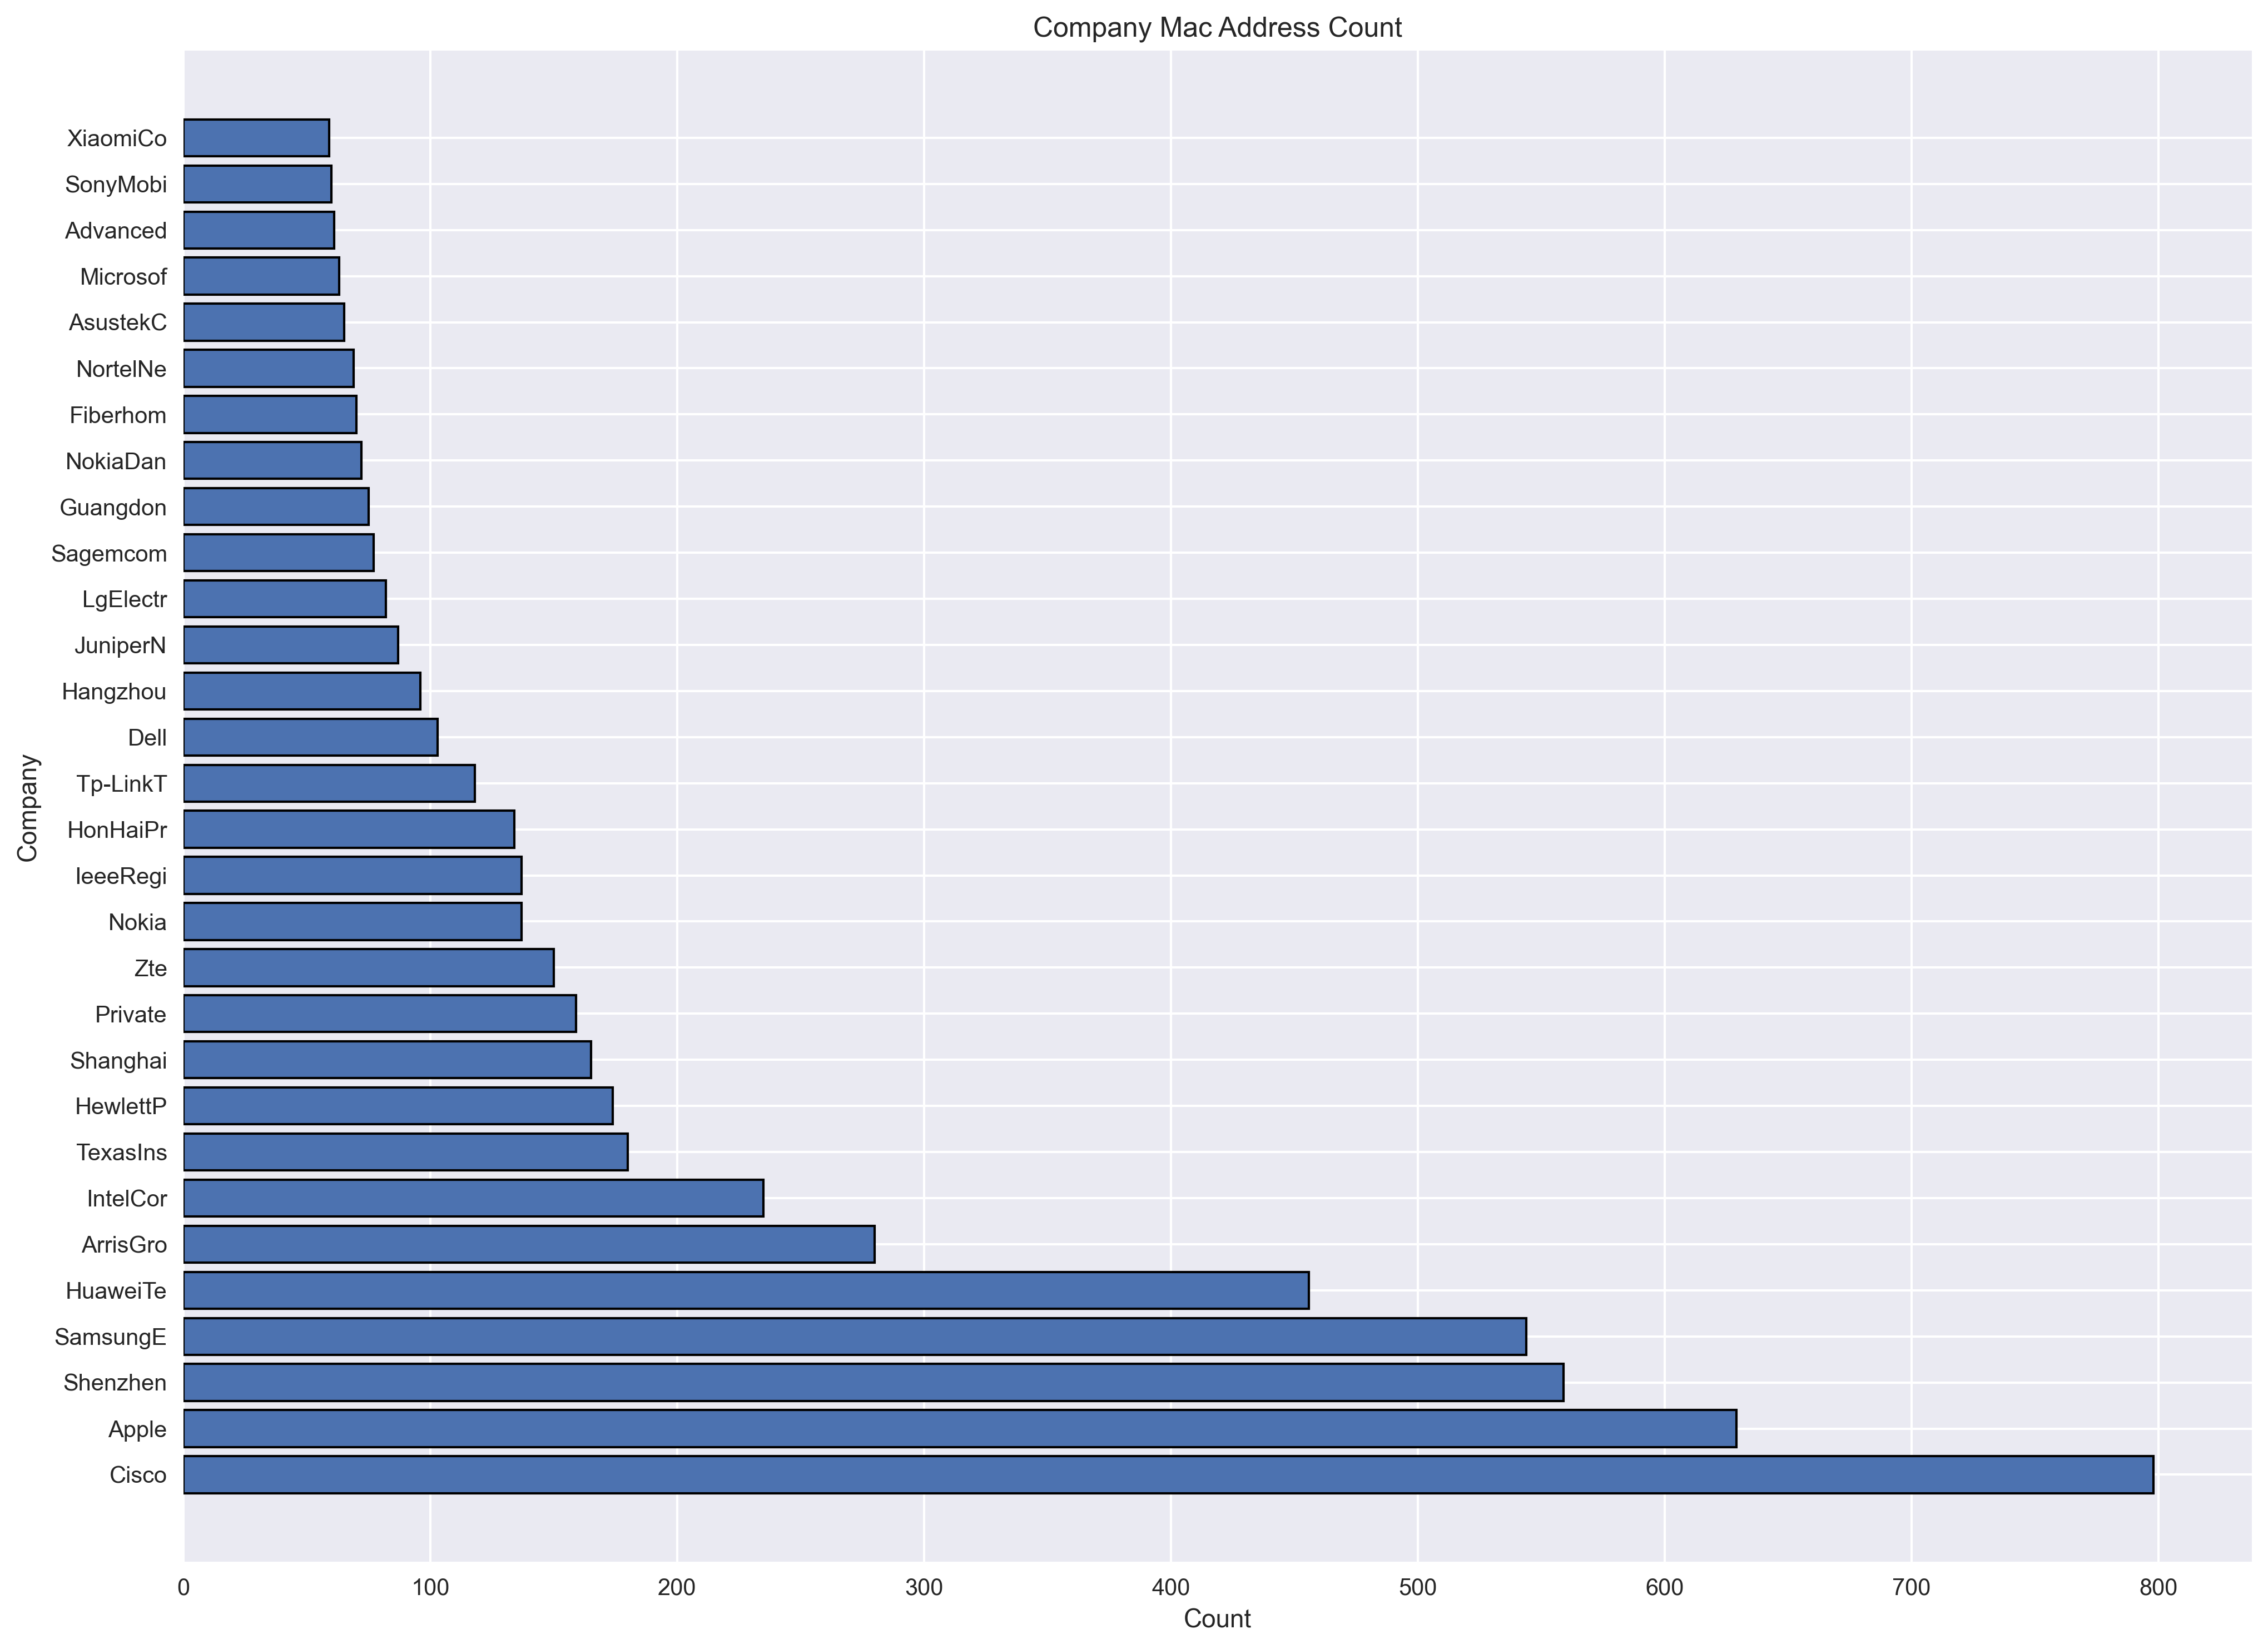

In [19]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #svg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize=(16, 12))

companies = df_addresses['company'].to_list()
counts = df_addresses['count'].to_list()
plt.style.use('seaborn')
plt.barh(companies[0:30], counts[0:30], edgecolor = 'k', linewidth = 1)
plt.title('Company Mac Address Count')
plt.xlabel('Count')
plt.ylabel('Company')

In [21]:
filename = 'updated_lan_macs.csv'
df_lm.toPandas().to_csv(filename)

In [22]:
df_mac = pd.read_csv('lan_mac_data/updated_lan_macs.csv', header=None, index_col = 0)
df_mac.replace('"', '', inplace=True, regex=True)
df_mac.to_csv("updated_lan_macs.csv",header=False, index=False)

21/08/11 13:00:48 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 453919 ms exceeds timeout 120000 ms
21/08/11 13:00:48 WARN SparkContext: Killing executors is not supported by current scheduler.


In [23]:
df_lm.limit(5).toPandas()

21/08/13 00:35:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/13 00:35:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/08/13 00:35:52 WARN TaskSetManager: Stage 24 contains a task of very large size (7183 KiB). The maximum recommended task size is 1000 KiB.


,SERIAL_NO,common__network_info__visible_lan_macs,manufacture_list
0,J170308C00247,"[{""mac"":""0e:11:45:27:cb:2f""},{""mac"":""74:8f:3c:...","[None, None, None]"
1,J160725003753,"[{""mac"":""4c:ed:fb:b2:ff:5d""},{""mac"":""b0:72:bf:...","[AsustekC, MurataMa]"
2,J191228F02970,"[{""mac"":""0c:98:38:27:98:9b"",""port"":3,""speed"":1...","[XiaomiCo, AsustekC, SamsungE, AsustekC, Tatun..."
3,J191210H00890,"[{""mac"":""00:0c:29:81:ba:35"",""port"":2,""speed"":1...","[Vmware, None, None]"
4,J160817001262,"[{""mac"":""00:56:2b:1e:65:45"",""port"":1,""speed"":1...","[Cisco, None, DeltaEle, Ubiquiti, Hangzhou, Ai..."
